책에서는 링크된 논문을 바탕으로 lstm 을 활용한, 다음날 주가 예측 프로젝트를 구현한다.

http://cs229.stanford.edu/proj2017/final-reports/5241098.pdf

# 데이터

이번 전략에 사용한 데이터는 크게 세 가지 카테고리로 나눌 수 있다.

* 주가의 기본적인 시가/고가/저가/종가 및 거래량 데이터

* 시가/고가/저가/종가 데이터를 활용해 가공한 기술 지표 데이터

* 시장 상황을 파악할 수 있는 시장 인덱스 데이터

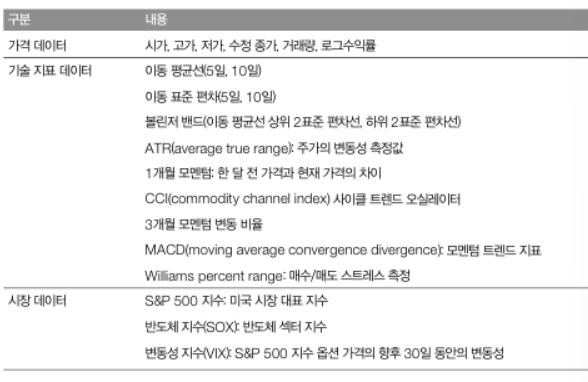

예제에서도 데이터 처리 과정은 가장 많은 시간과 수고를 요한다. 예제에서 데이터 가공은 크게 다섯 가지로 이뤄진다.

1. Raw 데이터 불러오기
2. 데이터 가공 및 결합하기
3. 훈련, 검증, 테스트 데이터셋 분리하기
4. 학습에 용이하도록 데이터 정규화하기
5. 특성 데이터, 레이블 데이터 나누기

In [ ]:
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109 kB 8.9 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


In [ ]:
import pandas as pd
import pandas_datareader as pdr
print(pdr.__version__)
tqqq_df = pdr.get_data_yahoo('TQQQ',start='2012-01-01')
nasdaq_df = pdr.get_data_yahoo('^IXIC',start='2012-01-01')
ndx_df = pdr.get_data_yahoo('^NDX',start='2012-01-01')
vix_df = pdr.get_data_yahoo('^VIX',start='2012-01-01')
snp500_df = pdr.get_data_yahoo('^GSPC', start='2012-01-01')
aapl_df = pdr.get_data_yahoo('AAPL',start='2012-01-01')
msft_df = pdr.get_data_yahoo('MSFT',start='2012-01-01')
amzn_df = pdr.get_data_yahoo('AMZN',start='2012-01-01')

0.10.0


티커 설명

* TQQQ : 인텔
* ^IXIC : 나스닥 종합지수
* ^NDX : 나스닥 100 지수
* ^VIX : 뉴욕 주식시장 변동성지수 (나스닥 100 변동성지수 선물 VOLQ 대체)
* ^GSPC : S&P 500 지수
* AAPL : 애플
* MSFT : 마이크로소프트
* AMZN : 아마존

In [1]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


퀀트 전략을 위한 인공지능 트레이딩 도서 p.290

In [2]:
# TA-Lib 설치
!pip install talib-binary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.4 MB 13.9 MB/s 


In [3]:
import pandas as pd
import pandas_datareader as pdr
import talib
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
from sklearn.preprocessing import MinMaxScaler

다음은 데이터 가공 및 결합하기 단계이다. 시고저종 데이터를 바탕으로 기술 지표 데이터를 만들어본다.

In [ ]:
tqqq_df.head()
df = tqqq_df

In [ ]:
# 새로운 데이터 컬럼 생성
df['next_rtn'] = df['Close'] / df['Open'] -1
df['log_return'] = np.log(1 + df['Adj Close'].pct_change())

# 이동평균
# 5일 이동평균
df['MA5'] = talib.SMA(df['Close'], timeperiod=5)
# 10일
df['MA10'] = talib.SMA(df['Close'], timeperiod=10)
# 각 이평선에 대한 표준편차
df['RASD5'] = talib.SMA(talib.STDDEV(df['Close'], timeperiod=5, nbdev=1), timeperiod=5)
df['RASD10'] = talib.SMA(talib.STDDEV(df['Close'], timeperiod=5, nbdev=1), timeperiod=10)

In [ ]:
df.head()

,High,Low,Open,Close,Volume,Adj Close,next_rtn,log_return,MA5,MA10,RASD5,RASD10
Date,,,,,,,,,,,,
2012-01-03,0.759792,0.743542,0.748125,0.748542,101366400.0,0.746671,0.000557,NaN,NaN,NaN,NaN,NaN
2012-01-04,0.761146,0.735417,0.745000,0.757500,59846400.0,0.755607,0.016779,0.011896,NaN,NaN,NaN,NaN
2012-01-05,0.778646,0.744792,0.753646,0.776146,69398400.0,0.774207,0.029855,0.024317,NaN,NaN,NaN,NaN
2012-01-06,0.789896,0.768646,0.778229,0.784167,103747200.0,0.782207,0.007630,0.010281,NaN,NaN,NaN,NaN
2012-01-09,0.791875,0.769792,0.790625,0.777604,76972800.0,0.775661,-0.016469,-0.008405,0.768792,NaN,NaN,NaN


In [ ]:
# MACD(Moving Average Convergence & Divergence)
macd, macdsignal, macdhist = talib.MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
df['MACD'] = macd

# 모멘텀 지표
# CCI : Commodity Channel Index
df['CCI'] = talib.CCI(df['High'], df['Low'], df['Close'], timeperiod=14)

# 변동성 지표
# ATR : Average True Range
df['ATR'] = talib.ATR(df['High'], df['Low'], df['Close'], timeperiod=14)

# 볼린저 밴드
upper, middle, lower = talib.BBANDS(df['Close'], timeperiod=20, nbdevup=2, nbdevdn=2,
                                    matype=0)
df['ub'] = upper
df['middle'] = middle
df['lb'] = lower

# MTM1, MTM3
df['MTM1'] = talib.MOM(df['Close'], timeperiod=1)
df['MTM3'] = talib.MOM(df['Close'], timeperiod=3)

# ROC : Rate of change : ((price/prevPrice)-1)*100
df['ROC'] = talib.ROC(df['Close'], timeperiod=60)

# WPR : william percent range (Williams' %R)
df['WPR'] = talib.WILLR(df['High'], df['Low'], df['Close'], timeperiod=14)

**MACD**

* 일반적으로 장-단기 이동 평균선은 서로 수렴과 확산의 과정을 지속하게 되는데, 이 때 장-단기 이동 평균선이 가장 크게 벌어진 시점이 바로 시세의 전환점일 수 있다고 보고 이를 이용해 매매 타이밍을 파악하고자 하는 것이 MACD 의 기본 원리이다.

* MACD 는 'MACD' 곡선과 'Signal' 곡선이라는 두 개의 이동 평균선을 이용한다. 'MACD' 곡선은 단기 이동평균에서 장기 이동평균을 뺀 값을 곡선으로 나타낸 것이다. 'Signal' 곡선은 MACD의 n 일 동안의 MACD 이동평균이다.

<br/></br>

**CCI**

* CCI 는 최근의 가격이 평균가격의 이동평균과 얼마나 떨어져 있는가를 표시하여 추세의 강도와 방향을 나타내어 주는데, 가격이 한 방향으로 계속 움직일 경우에는 현재 가격이 이동평균과 멀리 떨어지게 되며 이 경우를 추세가 강하다고 볼 수 있게 된다.

  > 절댓값이 클수록 추세는 강하고 (+) 값을 가질 경우에는 상승추세.

* CCI 는 상품의 일반 가격과 단순이동평균간의 차이를 일반가격의 평균 절대편차로 나눈 값으로 계산된다. 이 때 계산된 값은 더 읽기 쉬운 숫자를 제공하기 위해 0.015의 역률로 조정된다.

* 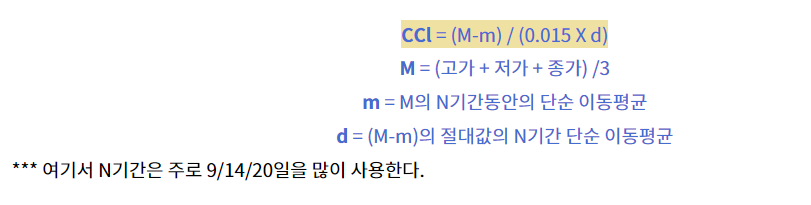

In [ ]:
df.head()

,High,Low,Open,Close,Volume,Adj Close,next_rtn,log_return,MA5,MA10,...,MACD,CCI,ATR,ub,middle,lb,MTM1,MTM3,ROC,WPR
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,0.759792,0.743542,0.748125,0.748542,101366400.0,0.746671,0.000557,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-04,0.761146,0.735417,0.745000,0.757500,59846400.0,0.755607,0.016779,0.011896,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.008958,NaN,NaN,NaN
2012-01-05,0.778646,0.744792,0.753646,0.776146,69398400.0,0.774207,0.029855,0.024317,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.018646,NaN,NaN,NaN
2012-01-06,0.789896,0.768646,0.778229,0.784167,103747200.0,0.782207,0.007630,0.010281,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.008021,0.035625,NaN,NaN
2012-01-09,0.791875,0.769792,0.790625,0.777604,76972800.0,0.775661,-0.016469,-0.008405,0.768792,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.006563,0.020104,NaN,NaN


가공된 데이터프레임 옆에 시장지수 데이터 + 기술주 데이터를 추가한다.


In [ ]:
nasdaq_df = nasdaq_df.loc[:, ['Close']].copy()
nasdaq_df.rename(columns={'Close' : 'NASDAQ'}, inplace=True)

ndx_df = ndx_df.loc[:, ['Close']].copy()
ndx_df.rename(columns={'Close' : 'NASDAQ_100'}, inplace=True)

vix_df = vix_df.loc[:, ['Close']].copy()
vix_df.rename(columns={'Close' : 'VIX'}, inplace=True)

snp500_df = snp500_df.loc[:, ['Close']].copy()
snp500_df.rename(columns={'Close' : 'S&P500'}, inplace=True)

aapl_df = aapl_df.loc[:, ['Close']].copy()
aapl_df.rename(columns={'Close' : 'Apple'}, inplace=True)

msft_df = msft_df.loc[:, ['Close']].copy()
msft_df.rename(columns={'Close' : 'MicroSoft'}, inplace=True)

amzn_df = amzn_df.loc[:, ['Close']].copy()
amzn_df.rename(columns={'Close' : 'Amazon'}, inplace=True)

df = df.join(nasdaq_df, how='left')
df = df.join(ndx_df, how='left')
df = df.join(vix_df, how='left')
df = df.join(snp500_df, how='left')
df = df.join(aapl_df, how='left')
df = df.join(msft_df, how='left')
df = df.join(amzn_df, how='left')

In [ ]:
df.head()

,High,Low,Open,Close,Volume,Adj Close,next_rtn,log_return,MA5,MA10,...,MTM3,ROC,WPR,NASDAQ,NASDAQ_100,VIX,S&P500,Apple,MicroSoft,Amazon
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,0.759792,0.743542,0.748125,0.748542,101366400.0,0.746671,0.000557,NaN,NaN,NaN,...,NaN,NaN,NaN,2648.719971,2321.959961,22.969999,1277.060059,14.686786,26.770000,8.9515
2012-01-04,0.761146,0.735417,0.745000,0.757500,59846400.0,0.755607,0.016779,0.011896,NaN,NaN,...,NaN,NaN,NaN,2648.360107,2329.709961,22.219999,1277.300049,14.765714,27.400000,8.8755
2012-01-05,0.778646,0.744792,0.753646,0.776146,69398400.0,0.774207,0.029855,0.024317,NaN,NaN,...,NaN,NaN,NaN,2669.860107,2348.979980,21.480000,1281.060059,14.929643,27.680000,8.8805
2012-01-06,0.789896,0.768646,0.778229,0.784167,103747200.0,0.782207,0.007630,0.010281,NaN,NaN,...,0.035625,NaN,NaN,2674.219971,2356.169922,20.629999,1277.810059,15.085714,28.110001,9.1305
2012-01-09,0.791875,0.769792,0.790625,0.777604,76972800.0,0.775661,-0.016469,-0.008405,0.768792,NaN,...,0.020104,NaN,NaN,2676.560059,2350.649902,21.070000,1280.699951,15.061786,27.740000,8.9280


완성한 데이터프레임을 드라이브에 저장한다.

이후 해당 파일을 실행할 때 라이브러리를 실행하고 데이터는 바로 꺼내오면 될 것 같다.

In [ ]:
df.to_csv('/content/drive/MyDrive/HAI/HAI_Stock/idea/data/tqqq_df.csv')

분석을 위한 변수가 모두 포함된 데이터프레임이 준비되었다. 이제 위 데이터의 학습, 검증, 테스트 데이터셋을 구간별로 나눠본다.

In [4]:
# p.293부터
df = pd.read_csv('/content/drive/MyDrive/HAI/HAI_Stock/idea/data/tqqq_df.csv')
df.set_index(['Date'], inplace=True)

In [6]:
df.tail()

,High,Low,Open,Close,Volume,Adj Close,next_rtn,log_return,MA5,MA10,...,MTM3,ROC,WPR,NASDAQ,NASDAQ_100,VIX,S&P500,Apple,MicroSoft,Amazon
Date,,,,,,,,,,,,,,,,,,,,,
2022-08-08,36.830002,34.439999,35.599998,34.930000,133893900.0,34.930000,-0.018820,-0.010254,35.002,33.137,...,-0.709999,21.453408,-19.427413,12644.459961,13159.160156,21.290001,4140.060059,164.869995,280.320007,139.410004
2022-08-09,34.369999,33.189999,34.279999,33.730000,109203000.0,33.730000,-0.016044,-0.034958,35.148,33.777,...,-2.420002,18.226424,-31.697357,12493.929688,13008.169922,21.770000,4122.470215,164.919998,282.299988,137.830002
2022-08-10,36.639999,35.310001,36.139999,36.500000,135777200.0,36.500000,0.009961,0.078925,35.320,34.353,...,1.209999,15.396778,-3.374251,12854.799805,13378.320312,19.740000,4210.240234,169.240005,289.160004,142.690002
2022-08-11,38.020000,35.669998,37.330002,35.950001,136680500.0,35.950001,-0.036968,-0.015183,35.280,34.786,...,1.020000,17.292010,-18.869640,12779.910156,13291.990234,20.200001,4207.270020,168.490005,287.019989,140.639999
2022-08-12,38.049999,36.240002,36.599998,37.980000,105378900.0,37.980000,0.037705,0.054931,35.818,35.248,...,4.250000,15.230584,-0.636361,13047.190430,13565.870117,19.530001,4280.149902,172.100006,291.910004,143.550003


In [7]:
# feature list
# feature_list = ['Adj Close', 'log_return', 'CCI','next_price']
feature1_list = ['Open','High','Low','Adj Close','Volume','log_return']
feature2_list = ['RASD5','RASD10','ub','lb','CCI','ATR','MACD','MA5','MA10','MTM1','MTM3','ROC','WPR']
feature3_list = ['NASDAQ', 'NASDAQ_100', 'VIX', 'S&P500', 'Apple', 'MicroSoft', 'Amazon']
# feature4_list = ['next_price']
feature4_list = ['next_rtn']


all_features = feature1_list + feature2_list + feature3_list + feature4_list

In [ ]:
df.head()

,High,Low,Open,Close,Volume,Adj Close,next_rtn,log_return,MA5,MA10,...,MTM3,ROC,WPR,NASDAQ,NASDAQ_100,VIX,S&P500,Apple,MicroSoft,Amazon
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,0.759792,0.743542,0.748125,0.748542,101366400.0,0.746671,0.000557,NaN,NaN,NaN,...,NaN,NaN,NaN,2648.719971,2321.959961,22.969999,1277.060059,14.686786,26.770000,8.9515
2012-01-04,0.761146,0.735417,0.745000,0.757500,59846400.0,0.755607,0.016779,0.011896,NaN,NaN,...,NaN,NaN,NaN,2648.360107,2329.709961,22.219999,1277.300049,14.765714,27.400000,8.8755
2012-01-05,0.778646,0.744792,0.753646,0.776146,69398400.0,0.774207,0.029855,0.024317,NaN,NaN,...,NaN,NaN,NaN,2669.860107,2348.979980,21.480000,1281.060059,14.929643,27.680000,8.8805
2012-01-06,0.789896,0.768646,0.778229,0.784167,103747200.0,0.782207,0.007630,0.010281,NaN,NaN,...,0.035625,NaN,NaN,2674.219971,2356.169922,20.629999,1277.810059,15.085714,28.110001,9.1305
2012-01-09,0.791875,0.769792,0.790625,0.777604,76972800.0,0.775661,-0.016469,-0.008405,0.768792,NaN,...,0.020104,NaN,NaN,2676.560059,2350.649902,21.070000,1280.699951,15.061786,27.740000,8.9280


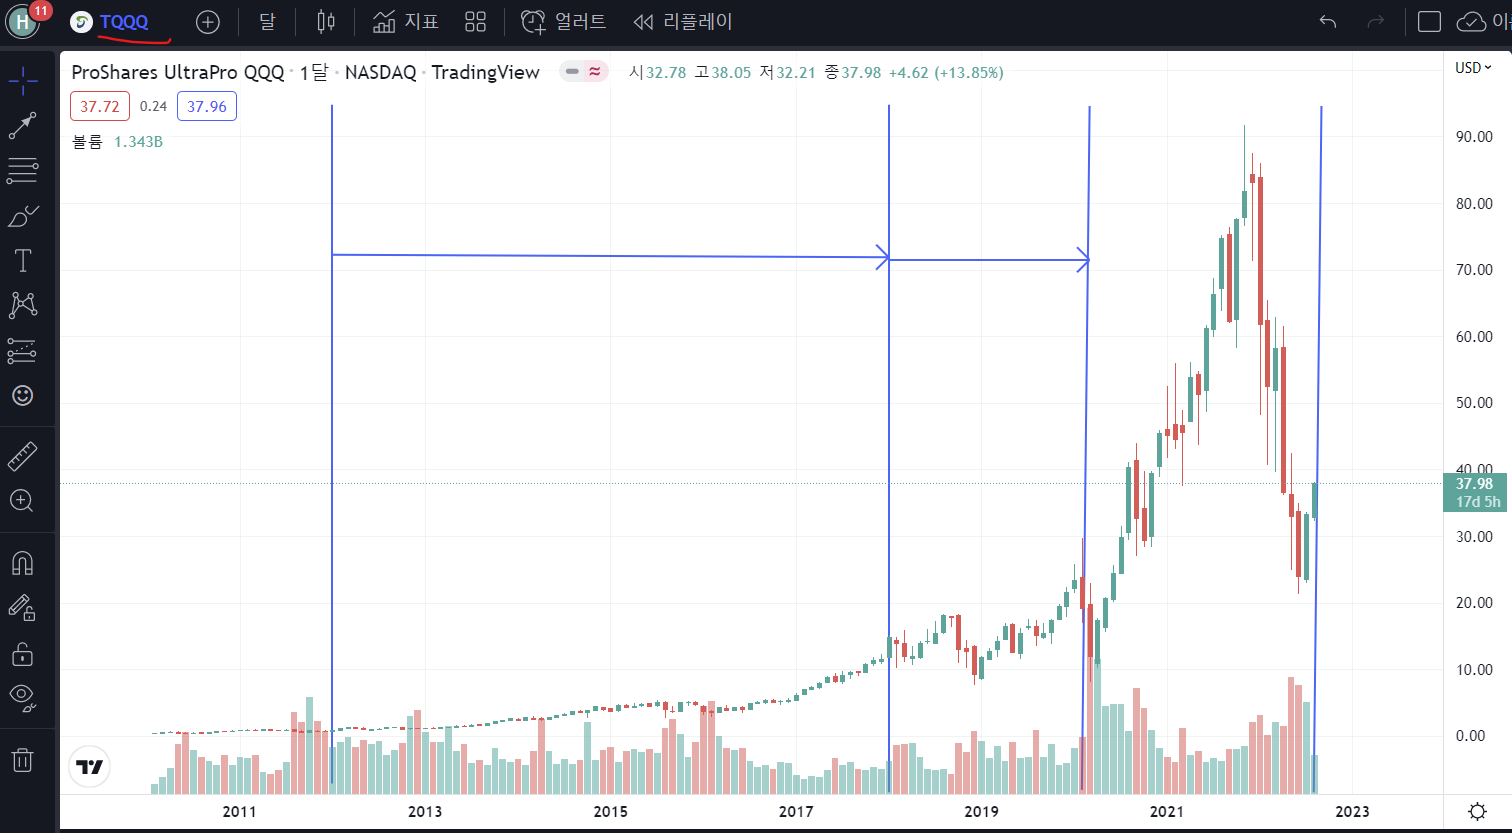

2012-01-01 부터 2018-01-01 변동성이 적은, 우상향 구간

2018-01-01 부터 2020-01-01 변동성이 중간 구간

2020-01-01 부터 2022-08-12 변동성이 매우 큰, 최근 구간

In [37]:
phase_flag = '2'

if phase_flag == '1' :
    train_from = '2012-01-01'
    train_to = '2014-01-01'

    val_from = '2014-01-01'
    val_to = '2016-01-01'

    test_from = '2016-01-01'
    test_to = '2018-01-01'

# elif phase_flag == '2' :
#     train_from = '2018-01-01'
#     train_to = '2019-01-01'

#     val_from = '2019-01-01'
#     val_to = '2020-01-01'

#     test_from = '2018-01-01'
#     test_to = '2020-01-01'
    
else : 
    train_from = '2018-01-01'
    train_to = '2022-01-01'

    val_from = '2022-01-01'
    val_to = '2022-04-01'

    test_from = '2021-04-01'
    test_to = '2022-08-12'

In [38]:
train_df = df.loc[train_from:train_to, all_features].copy()
val_df = df.loc[val_from:val_to,all_features].copy()
test_df   = df.loc[test_from:test_to,all_features].copy()

In [39]:
test_df.head()

,Open,High,Low,Adj Close,Volume,log_return,RASD5,RASD10,ub,lb,...,ROC,WPR,NASDAQ,NASDAQ_100,VIX,S&P500,Apple,MicroSoft,Amazon,next_rtn
Date,,,,,,,,,,,,,,,,,,,,,
2021-04-01,47.320000,48.014999,47.209999,47.950001,72543600.0,0.049593,1.113844,1.302435,48.293642,39.869358,...,7.625832,-0.904014,13480.110352,13329.519531,17.330000,4019.870117,123.000000,242.350006,158.050003,0.013314
2021-04-05,49.105000,51.189999,48.985001,50.830002,65269800.0,0.058328,1.393259,1.392101,49.537018,39.520981,...,19.011948,-3.473197,13705.589844,13598.160156,17.910000,4077.909912,125.900002,249.070007,161.336502,0.035129
2021-04-06,50.680000,51.639999,50.355000,50.709999,60303400.0,-0.002364,1.756745,1.501004,49.989028,40.309972,...,10.732615,-8.599172,13698.379883,13578.459961,18.120001,4073.939941,126.209999,247.860001,161.190994,0.000592
2021-04-07,50.514999,51.490002,50.049999,51.084999,49493600.0,0.007368,2.025656,1.557884,50.919335,40.207164,...,7.389110,-5.131765,13688.839844,13616.700195,17.160000,4079.949951,127.900002,249.899994,163.969498,0.011284
2021-04-08,52.459999,52.770000,52.049999,52.680000,56809600.0,0.030745,2.124154,1.590819,52.060401,40.089598,...,15.862983,-0.753455,13829.309570,13758.509766,16.950001,4097.169922,130.360001,253.250000,164.964996,0.004194


다음은 데이터 전처리의 마지막 단계인 정규화다. 학습을 진행할 때 각각의 특성 데이터가 상이한 범주를 가진다면 학습 과정이 원활하지 않을 수 있다. 정규화는 min-max normalization 방법을 사용한다.

In [33]:
def min_max_normal(tmp_df):
    eng_list = []
    sample_df = tmp_df.copy()
    for x in all_features:
        if x in feature4_list :
            continue
        series = sample_df[x].copy()
        values = series.values
        values = values.reshape((len(values), 1))
        # train the normalization
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaler = scaler.fit(values)
#         print('columns : %s , Min: %f, Max: %f' % (x, scaler.data_min_, scaler.data_max_))
        # normalize the dataset and print
        normalized = scaler.transform(values)
        new_feature = '{}_normal'.format(x)
        eng_list.append(new_feature)
        sample_df[new_feature] = normalized
    return sample_df, eng_list

In [34]:
train_sample_df, eng_list =  min_max_normal(train_df)
val_sample_df, eng_list =  min_max_normal(val_df)
test_sample_df, eng_list = min_max_normal(test_df)

In [40]:
train_sample_df.head()

,Open,High,Low,Adj Close,Volume,log_return,RASD5,RASD10,ub,lb,...,MTM3_normal,ROC_normal,WPR_normal,NASDAQ_normal,NASDAQ_100_normal,VIX_normal,S&P500_normal,Apple_normal,MicroSoft_normal,Amazon_normal
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,11.741667,12.178333,11.657500,12.128244,45867600.0,0.050052,0.125345,0.160820,12.419846,10.841237,...,0.677629,0.568088,0.854563,0.412961,0.314425,0.022009,0.562122,0.334557,0.017813,0.000000
2018-01-03,12.202500,12.555000,12.200833,12.483344,42612000.0,0.028858,0.173052,0.166586,12.511396,10.912271,...,0.746043,0.590360,0.956035,0.442706,0.347542,0.000000,0.590252,0.334223,0.025393,0.017860
2018-01-04,12.655833,12.700833,12.538333,12.556526,35012400.0,0.005845,0.230775,0.179779,12.590035,11.001965,...,0.808477,0.597862,0.900421,0.448987,0.352054,0.002485,0.608075,0.343124,0.039795,0.024198
2018-01-05,12.758333,12.990000,12.692500,12.935741,41190000.0,0.029754,0.305154,0.204764,12.759427,11.024490,...,0.763454,0.623122,0.980881,0.478743,0.387355,0.002485,0.639319,0.365042,0.060262,0.047184
2018-01-08,12.960833,13.133333,12.948333,13.079611,36126000.0,0.011060,0.348639,0.228060,12.938380,11.040953,...,0.718783,0.625329,0.983140,0.489311,0.399346,0.013135,0.646756,0.357810,0.061967,0.068031


# 훈련데이터 구분하기

다음 코드는 학습에 사용하는 데이터와 레이블 데이터를 나눈다.

In [41]:
def create_dateset_binary(data, feature_list, step, n):
    '''
    다음날 시종가 수익률 라벨링.
    '''
    train_xdata = np.array(data[feature_list[0:n]])
    
    # 가장 뒤 n step을 제외하기 위해. 왜냐하면 학습 input으로는 어차피 10개만 주려고 하니깐.
    m = np.arange(len(train_xdata) - step)
    #     np.random.shuffle(m)  # shuffle은 빼자.
    x, y = [], []
    for i in m:
        a = train_xdata[i:(i+step)]
        x.append(a)
    x_batch = np.reshape(np.array(x), (len(m), step, n))
    
    train_ydata = np.array(data[[feature_list[n]]])
    # n_step 이상부터 답을 사용할 수 있는거니깐. 
    for i in m + step :
        next_rtn = train_ydata[i][0]
        if next_rtn > 0 :
            label = 1
        else :
            label = 0
        y.append(label)
    y_batch = np.reshape(np.array(y), (-1,1))
    return x_batch, y_batch

현재 데이터셋에는 레이블된 데이터('Close' 컬럼)가 같이 있으므로 이를 구분하기 위해 레이블 데이터를 나눌 필요가 있다. 다음의 과정을 통해 특성 데이터와 레이블 데이터를 구분한다.

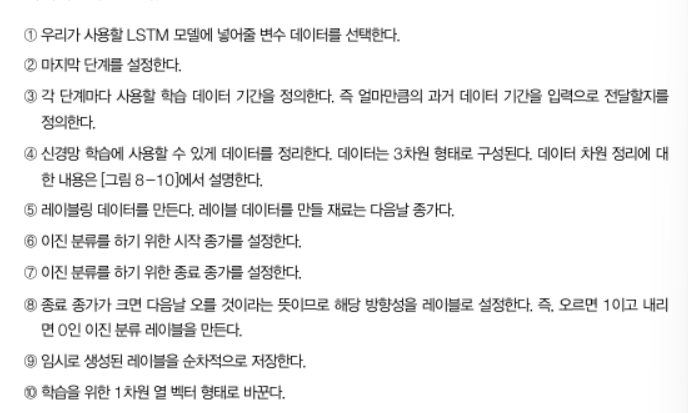

다음 그림처럼, 특정 색상으로 표시된 영역 데이터를 읽으면 다음 칸에 나타나는 종가를 예측할 수 있게 변수 데이터와 레이블 데이터를 설정하는 과정이고, 이는 훈련/검증/테스트 데이터에도 적용된다.

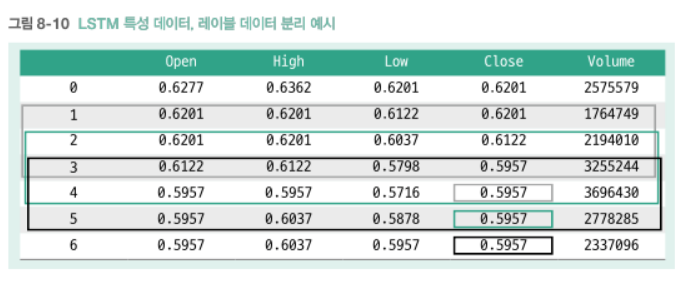

In [42]:
num_step = 5
num_unit = 200

In [43]:
eng_list = eng_list + feature4_list
n_feature = len(eng_list)-1
# LSTM할때 사용했던 소스코드.
x_train, y_train = create_dateset_binary(train_sample_df[eng_list], eng_list, num_step, n_feature)
x_val, y_val = create_dateset_binary(val_sample_df[eng_list], eng_list, num_step, n_feature)
x_test, y_test = create_dateset_binary(test_sample_df[eng_list], eng_list, num_step, n_feature)

In [44]:
x_train.shape

(371, 5, 26)

데이터의 shape 을 살펴보면 다음의 해석을 할 수 있다.

1개의 시점에 26개의 변수를 사용하고, 5일 데이터로 1 step 을 학습한다. 즉 5일이라는 타임라인에 걸친 22개의 변수를 사용해 다음날 종가를 예측하는 것이다.

In [45]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, 2)
y_val = to_categorical(y_val, 2)
y_test = to_categorical(y_test, 2)

In [46]:
print(pd.DataFrame(y_train).sum())
print(pd.DataFrame(y_val).sum())
print(pd.DataFrame(y_test).sum())

0    179.0
1    192.0
dtype: float32
0    167.0
1    209.0
dtype: float32
0    186.0
1    215.0
dtype: float32


# 모델 구조

In [47]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, LSTM
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers

책에서 참고한 논문은 5개의 LSTM 층과 200개의 뉴런을 사용해 모델링한다. 이에 각 LSTM 층에 200개의 뉴런을 사용할 수 있게 매개변수를 전달하고 5개의 LSTM 층을 겹겹이 쌓아올리고 L2 정규화 방법을 각 층에 적용한다.

In [48]:
# LSTM 모델을 생성한다.
K.clear_session()
input_layer = Input(batch_shape=(None, x_train.shape[1], x_train.shape[2]))
layer_lstm_1 = LSTM(num_unit, return_sequences = True, recurrent_regularizer = regularizers.l2(0.01))(input_layer)
layer_lstm_1 = BatchNormalization()(layer_lstm_1)
layer_lstm_2 = LSTM(num_unit, return_sequences = True, recurrent_regularizer = regularizers.l2(0.01))(layer_lstm_1)
layer_lstm_2 = Dropout(0.25)(layer_lstm_2)
layer_lstm_3 = LSTM(num_unit, return_sequences = True, recurrent_regularizer = regularizers.l2(0.01))(layer_lstm_2)
layer_lstm_3 = BatchNormalization()(layer_lstm_3)
layer_lstm_4 = LSTM(num_unit, return_sequences = True, recurrent_regularizer = regularizers.l2(0.01))(layer_lstm_3)
layer_lstm_4 = Dropout(0.25)(layer_lstm_4)
layer_lstm_5 = LSTM(num_unit , recurrent_regularizer = regularizers.l2(0.01))(layer_lstm_4)
layer_lstm_5 = BatchNormalization()(layer_lstm_5)
output_layer = Dense(2, activation='sigmoid')(layer_lstm_5)

model = Model(input_layer, output_layer)
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [49]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 26)]           0         
                                                                 
 lstm (LSTM)                 (None, 5, 200)            181600    
                                                                 
 batch_normalization (BatchN  (None, 5, 200)           800       
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 5, 200)            320800    
                                                                 
 dropout (Dropout)           (None, 5, 200)            0         
                                                                 
 lstm_2 (LSTM)               (None, 5, 200)            320800    
                                                             

**네트워크에 대한 설명은 다음과 같다.**
<br/></br>
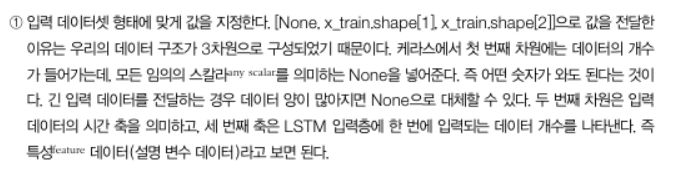

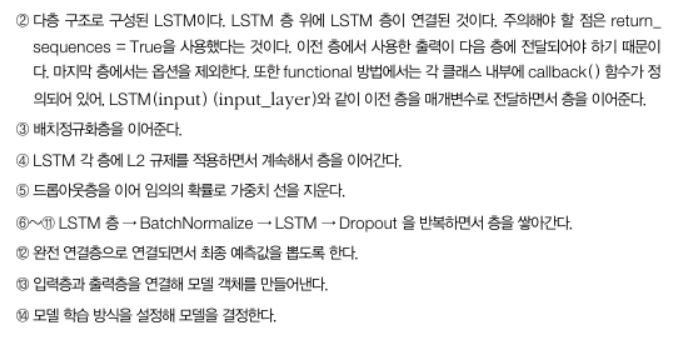

참고로 배치정규화는 신경망의 입력값을 평균 0, 분산 1로 정규화해 네트워크 학습이 원활히 일어나도록 돕는 방식이다. 케라스에서 배치정규화층은 원하는 곳에 추가할 수 있다. 일반적으로 fully-connected layer > batchnormalization > activation function 순으로 위치시킨다.

# 모델 학습 진행

**훈련 설정과 관련된 사항들**

* 논문에서 펼쳐진 셀을 10으로 설명했지만, 5일치 데이터를 사용해 다음날 종가를 예측한다고 했기에, lstm 셀을 5개로 두는 대신 배치 사이즈를 10으로 두어 lstm 모델을 구현했다.

* 평의 상 학습 수를 20번으로 설정했지만, 논문에서는 5000번을 학습했다.

* verbose 옵션에 따라 학습 진행 중에 로그를 어떻게 보지 설정할 수 있다. 0=silent, 1=progress bar, 2=one line per epoch 을 의미한다.


In [71]:
history = model.fit(
    x_train,y_train,
    epochs= 100,
    batch_size= 10, 
    validation_data=(x_val, y_val))

Epoch 1/100
38/38 [==============================] - 5s 127ms/step - loss: 0.7407 - accuracy: 0.5310 - val_loss: 0.7333 - val_accuracy: 0.5266
Epoch 2/100
38/38 [==============================] - 4s 118ms/step - loss: 0.7280 - accuracy: 0.5040 - val_loss: 0.7460 - val_accuracy: 0.4601
Epoch 3/100
38/38 [==============================] - 3s 76ms/step - loss: 0.7064 - accuracy: 0.5768 - val_loss: 0.7913 - val_accuracy: 0.5532
Epoch 4/100
38/38 [==============================] - 3s 75ms/step - loss: 0.7518 - accuracy: 0.5606 - val_loss: 0.7492 - val_accuracy: 0.4947
Epoch 5/100
38/38 [==============================] - 3s 76ms/step - loss: 0.7232 - accuracy: 0.5445 - val_loss: 0.7287 - val_accuracy: 0.5372
Epoch 6/100
38/38 [==============================] - 3s 75ms/step - loss: 0.7180 - accuracy: 0.5256 - val_loss: 0.7424 - val_accuracy: 0.5372
Epoch 7/100
38/38 [==============================] - 3s 75ms/step - loss: 0.7185 - accuracy: 0.5687 - val_loss: 0.7893 - val_accuracy: 0.5372
Epoc

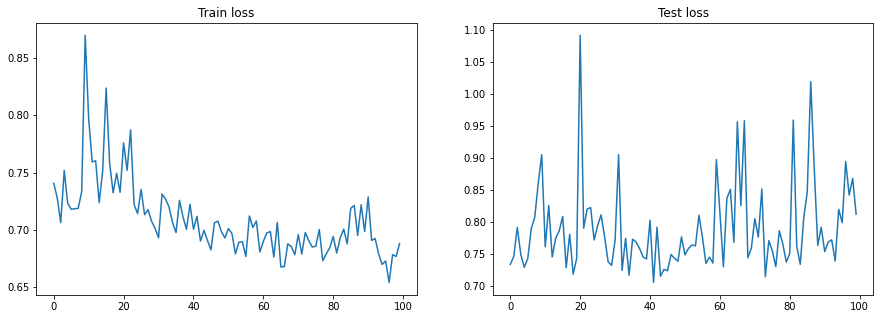

In [72]:
def plot_history(history):
    plt.figure(figsize=(15, 5))
    ax = plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.title("Train loss")
    ax = plt.subplot(1, 2, 2)
    plt.plot(history.history["val_loss"])
    plt.title("Test loss")

plot_history(history)

# 모델을 활용한 결과 예측

학습된 모델로 예측값을 만들어본다. 그리고 평가 지표를 사용해 평가한다. 분류 모델 평가이므로 혼동 행렬을 사용한다.

In [75]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [76]:
predicted = model.predict(x_test)

# 다음 두 코드는 원-핫 인코딩으로 되어있는 예측값과 실제 레이블 데이터를 다른 범주로 바꾼다.
y_pred = np.argmax(predicted, axis=1)
Y_test = np.argmax(y_test, axis=1)

# 사이킷런 혼동 행렬 함수 호출
cm = confusion_matrix(Y_test, y_pred)

# 혼동 행렬에서 계산된 수치를 바탕으로 더 많은 수치 계산을 연산하는 리포트 함수 호출
report = classification_report(Y_test, y_pred)

혼동 행렬에서 계산된 값과 리포트 함수를 통해 나온 값을 살펴본다.

# ROC curve, AUC 확인

In [77]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

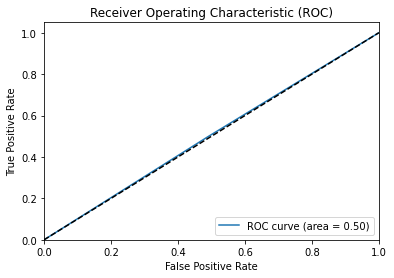

ROC AUC 값 : 0.5042


In [78]:
plot_roc(y_pred,Y_test)
from sklearn.metrics import roc_auc_score
roc_score = roc_auc_score(Y_test,y_pred)
print('ROC AUC 값 : {0:.4f}'.format(roc_score))

# Drop & Batch

In [80]:
tn = cm[0][0]
fn = cm[1][0]
tp = cm[1][1]
fp = cm[0][1]
if tp == 0:
    tp = 1
if tn == 0:
    tn = 1
if fp == 0:
    fp = 1
if fn == 0:
    fn = 1
TPR = float(tp)/(float(tp)+float(fn))
FPR = float(fp)/(float(fp)+float(tn))
accuracy = round((float(tp) + float(tn))/(float(tp) +
                                          float(fp) + float(fn) + float(tn)), 3)
specitivity = round(float(tn)/(float(tn) + float(fp)), 3)
sensitivity = round(float(tp)/(float(tp) + float(fn)), 3)
mcc = round((float(tp)*float(tn) - float(fp)*float(fn))/math.sqrt(
    (float(tp)+float(fp))
    * (float(tp)+float(fn))
    * (float(tn)+float(fp))
    * (float(tn)+float(fn))
), 3)


f_output = open('/content/drive/MyDrive/HAI/HAI_Stock/idea/model/lstm_phase2_model_info_epochs_100.txt', 'a')
f_output.write('=======\n')
f_output.write('{}epochs_{}batch\n'.format(
    # 20, 10))     <-- 학습 진행 때마다, epochs, batch 변경된 값 직접 입력.
f_output.write('TN: {}\n'.format(tn))
f_output.write('FN: {}\n'.format(fn))
f_output.write('TP: {}\n'.format(tp))
f_output.write('FP: {}\n'.format(fp))
f_output.write('TPR: {}\n'.format(TPR))
f_output.write('FPR: {}\n'.format(FPR))
f_output.write('accuracy: {}\n'.format(accuracy))
f_output.write('specitivity: {}\n'.format(specitivity))
f_output.write("sensitivity : {}\n".format(sensitivity))
f_output.write("mcc : {}\n".format(mcc))
f_output.write("{}".format(report))
f_output.write('=======\n')
f_output.close()

In [81]:
# 예측.
# y_hat = model.predict(x_test, batch_size = 1)
print(len(y_test))
print(len(y_pred))

401
401


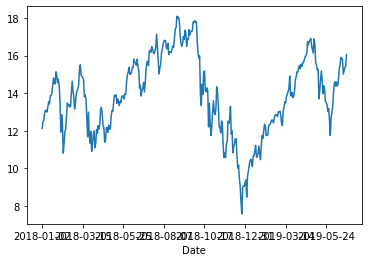

In [82]:
train_sample_df['Adj Close'].plot()

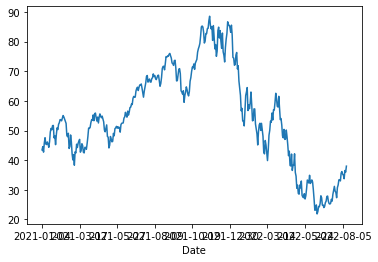

In [83]:
test_sample_df['Adj Close'].plot()

In [84]:
lstm_book_df = test_sample_df[['Adj Close','next_rtn']].copy()

t1 = pd.DataFrame(data = y_pred,columns=['position'],index = lstm_book_df.index[5:])
lstm_book_df = lstm_book_df.join(t1,how='left')
lstm_book_df.fillna(0,inplace=True)
lstm_book_df['ret'] = lstm_book_df['Adj Close'].pct_change()
lstm_book_df['lstm_ret'] = lstm_book_df['next_rtn'] * lstm_book_df['position'].shift(1)
lstm_book_df['lstm_cumret'] = (lstm_book_df['lstm_ret'] + 1).cumprod()
lstm_book_df['bm_cumret'] = (lstm_book_df['ret'] + 1).cumprod()

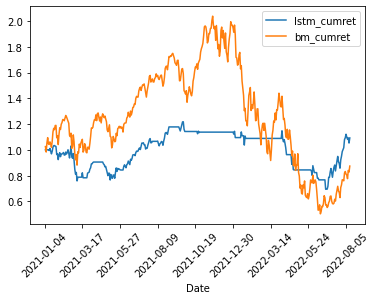

In [85]:
lstm_book_df[['lstm_cumret','bm_cumret']].plot()
plt.xticks(rotation=45)
plt.show()

# Backtesting

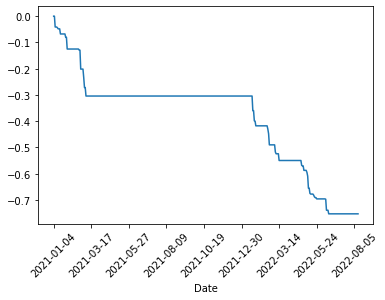

In [86]:
historical_max = lstm_book_df['Adj Close'].cummax()
daily_drawdown = lstm_book_df['Adj Close'] / historical_max - 1.0
historical_dd = daily_drawdown.cummin()
historical_dd.plot()
plt.xticks(rotation=45)
plt.show()

## 바이앤홀드 전략 BM

In [87]:
CAGR = lstm_book_df.loc[lstm_book_df.index[-1],'bm_cumret'] ** (252./len(lstm_book_df.index)) -1
Sharpe = np.mean(lstm_book_df['ret']) / np.std(lstm_book_df['ret']) * np.sqrt(252.)
VOL = np.std(lstm_book_df['ret']) * np.sqrt(252.)
MDD = historical_dd.min()
print('CAGR : ',round(CAGR*100,2),'%')
print('Sharpe : ',round(Sharpe,2))
print('VOL : ',round(VOL*100,2),'%')
print('MDD : ',round(-1*MDD*100,2),'%')

CAGR :  -8.03 %
Sharpe :  0.26
VOL :  74.23 %
MDD :  75.32 %


## LSTM 전략

In [88]:
CAGR = lstm_book_df.loc[lstm_book_df.index[-1],'lstm_cumret'] ** (252./len(lstm_book_df.index)) -1
Sharpe = np.mean(lstm_book_df['lstm_ret']) / np.std(lstm_book_df['lstm_ret']) * np.sqrt(252.)
VOL = np.std(lstm_book_df['lstm_ret']) * np.sqrt(252.)
MDD = historical_dd.min()
print('CAGR : ',round(CAGR*100,2),'%')
print('Sharpe : ',round(Sharpe,2))
print('VOL : ',round(VOL*100,2),'%')
print('MDD : ',round(-1*MDD*100,2),'%')

CAGR :  5.63 %
Sharpe :  0.33
VOL :  37.02 %
MDD :  75.32 %


# 모델 저장

지금은 첫 번째 구간(phase1) 에 대해 모델을 학습시켰기에, 'lstm_phase1.h5' 라는 이름의 모델을 저장시킨다.

이후, 순차적으로 두 번째 구간, 세 번째 구간에 대해 모델 학습을 진행해서 각각 모델을 다른 이름으로 저장한다.

In [58]:
model.save('/content/drive/MyDrive/HAI/HAI_Stock/idea/model/lstm_phase2.h5')